The notebook aims to construct an XGBoost Model for modeling the Probability of Default.

# 0. Import Libraries


In [1]:
# === Standard libraries ===

import os
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# === WandB Logging  ===
import wandb

wandb.login(key=os.getenv("WANDB_API_KEY"))

# == Global Functions ==
from functions import *
import math


# === Spark Session & Functions ===
from init_spark import start_spark

spark = start_spark()
from pyspark.sql.functions import (
    col,
    when,
    count,
    desc,
    isnan,
    isnull,
    lit,
    length,
    trim,
    lower,
    upper,
    to_date,
    concat_ws,
    regexp_extract,
    mean,
)
from pyspark.sql.types import (
    StructType,
    StructField,
    StringType,
    DoubleType,
    IntegerType,
    DateType,
    NumericType,
    FloatType,
    LongType,
)


# === Pandas Dataframe & WoE Binning ===
import pandas as pd
from tabulate import tabulate
from optbinning import OptimalBinning
import numpy as np

# == Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

# === Machine Learning ===
from sklearn.linear_model import LogisticRegression as SkLogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    ConfusionMatrixDisplay,
)

# == Optbinning ==
from optbinning import OptimalPWBinning


# === Load Environment Variables ===
from dotenv import load_dotenv

load_dotenv()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc
wandb: Currently logged in as: wlunlun1212 (wlunlun1212-singapore-management-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/24 23:41:56 WARN Utils: Your hostname, Chengs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.77 instead (on interface en0)
25/0

4.0.0


True

In [2]:
# -----------------
# Global Variables
# -----------------

# == 1. Remove all existing runs every time I run this notebook
NOTEBOOK_RUN_NAME = "XG Boost"
MODEL_NAME = "XGBoost"
api = wandb.Api()
for run in api.runs(
    f"wlunlun1212-singapore-management-university/Credit Risk Modeling"
):
    if run.group == NOTEBOOK_RUN_NAME:
        run.delete()

In [3]:
# -----------------
# Global Functions
# -----------------


def train_test_split_oot(pdf):
    """Sorts Pandas Dataframe & Conducts 80-20 OOT Split on Pandas Dataframe"""
    pdf_sorted = pdf.sort_values("issue_d", ascending=True)
    split_idx = int(len(pdf_sorted) * 0.8)
    train_pdf = pdf_sorted.iloc[:split_idx]
    test_pdf = pdf_sorted.iloc[split_idx:]

    display(train_pdf.head())
    display(test_pdf.head())

    return train_pdf, test_pdf

In [4]:
# ------------------------------------
# Reading from Medallion Data Pipeline
# ------------------------------------

df = spark.read.format("delta").load("../data/gold/medallion_cleaned_lc_data")

df.limit(10).toPandas()

25/08/24 23:42:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
0,87704389,1000.0,1000.0,36,10.49,32.50,B,2,MORTGAGE,39975.0,...,100.0,0.0,0.0,0.0,146014.0,60931.0,8300.0,70423.0,10,762.0
1,88862675,4800.0,4800.0,36,18.99,175.93,D,6,MORTGAGE,132000.0,...,78.6,0.0,0.0,0.0,314046.0,53279.0,500.0,54636.0,17,662.0
2,85636448,4075.0,4075.0,36,14.49,140.25,C,1,RENT,12000.0,...,100.0,0.0,0.0,0.0,27142.0,18772.0,5200.0,20342.0,4,752.0
3,88012886,23975.0,23975.0,60,15.59,577.82,C,2,RENT,89999.0,...,95.2,0.0,0.0,0.0,48652.0,14397.0,31500.0,12684.0,18,732.0
4,87989149,8000.0,8000.0,36,12.79,268.75,C,10,OWN,30000.0,...,100.0,20.0,1.0,0.0,55262.0,29807.0,11600.0,34562.0,9,707.0
5,85582885,5600.0,5600.0,36,12.79,188.13,C,10,MORTGAGE,109000.0,...,81.2,0.0,0.0,0.0,421855.0,50608.0,3000.0,58902.0,17,702.0
6,88494037,6000.0,6000.0,36,10.49,194.99,B,0,OWN,55000.0,...,100.0,0.0,0.0,0.0,27352.0,7421.0,19500.0,7852.0,15,807.0
7,88143505,24000.0,24000.0,60,15.59,578.42,C,10,MORTGAGE,65000.0,...,94.7,50.0,0.0,0.0,310036.0,38795.0,14000.0,28679.0,13,682.0
8,86216472,3200.0,3200.0,36,9.49,102.50,B,6,MORTGAGE,72000.0,...,94.3,0.0,0.0,0.0,112899.0,60713.0,4000.0,57816.0,12,747.0
9,87624578,3600.0,3600.0,36,8.59,113.80,A,0,RENT,70000.0,...,56.2,100.0,0.0,0.0,63980.0,40699.0,7500.0,54780.0,30,692.0


In [5]:
# ---------------------------
# Convert to Pandas Dataframe
# ---------------------------
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
pdf = df.toPandas()

In [6]:
# ---------------------------------------------
# Data Leakage Removal & Useless Column Removal
# ---------------------------------------------

post_loan_origination_features = [
    "funded_amnt",
    "out_prncp",
    "total_pymnt",
    "total_rec_prncp",
    "total_rec_int",
    "total_rec_late_fee",
    "recoveries",
    "collection_recovery_fee",
    "last_pymnt_amnt",
    "tot_coll_amt",
    "last_fico_range_high",
    "last_fico_range_low",
]


# == total_pymnt_inv, total_rec_prncp_inv, total_rec_int_inv, out_prncp_inv removed prvsly ==


pdf = pdf.drop(columns=post_loan_origination_features)
print("✅ Post Loan Origination Features Dropped ...")

# == Assert none of these columns are in pdf.columns ==
assert not any(
    col in pdf.columns for col in post_loan_origination_features
), f"Some post-loan origination features are still present in pdf: {set(pdf.columns) & set(post_loan_origination_features)}"

✅ Post Loan Origination Features Dropped ...


Base Model Performance can be found in Wandb as shown below.

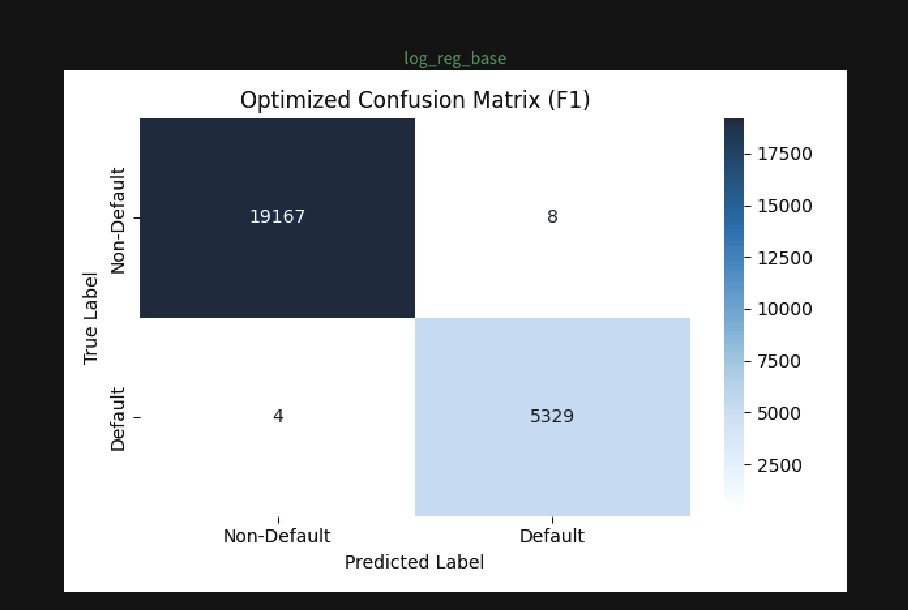


In [7]:
f"Current Dataset has {pdf.shape[0]} rows, {pdf.shape[1]} columns"

'Current Dataset has 1339155 rows, 63 columns'

# 1. Data Inspection & Preparation


In [8]:
pdf.head()

,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
0,87704389,1000.0,36,10.49,32.50,B,2,MORTGAGE,39975.0,Source Verified,...,100.0,0.0,0.0,0.0,146014.0,60931.0,8300.0,70423.0,10,762.0
1,88862675,4800.0,36,18.99,175.93,D,6,MORTGAGE,132000.0,Source Verified,...,78.6,0.0,0.0,0.0,314046.0,53279.0,500.0,54636.0,17,662.0
2,85636448,4075.0,36,14.49,140.25,C,1,RENT,12000.0,Verified,...,100.0,0.0,0.0,0.0,27142.0,18772.0,5200.0,20342.0,4,752.0
3,88012886,23975.0,60,15.59,577.82,C,2,RENT,89999.0,Source Verified,...,95.2,0.0,0.0,0.0,48652.0,14397.0,31500.0,12684.0,18,732.0
4,87989149,8000.0,36,12.79,268.75,C,10,OWN,30000.0,Verified,...,100.0,20.0,1.0,0.0,55262.0,29807.0,11600.0,34562.0,9,707.0


In [9]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339155 entries, 0 to 1339154
Data columns (total 63 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1339155 non-null  int32  
 1   loan_amnt                   1339155 non-null  float64
 2   term                        1339155 non-null  int32  
 3   int_rate                    1339155 non-null  float64
 4   installment                 1339155 non-null  float64
 5   grade                       1339155 non-null  object 
 6   emp_length                  1339155 non-null  int32  
 7   home_ownership              1339155 non-null  object 
 8   annual_inc                  1339155 non-null  float64
 9   verification_status         1339155 non-null  object 
 10  issue_d                     1339155 non-null  object 
 11  default_status              1339155 non-null  int32  
 12  dti                         1339155 non-null  float64
 1

In [10]:
pd.set_option("display.max_columns", None)
pdf.describe(include="all")

,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
count,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1339155,1.339155e+06,1339155,1.339155e+06,1339155,1339155,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1339155,1.339155e+06,1339155,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06
unique,NaN,NaN,NaN,NaN,NaN,7,NaN,4,NaN,3,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,B,NaN,MORTGAGE,NaN,Source Verified,2016-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,w,NaN,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,391509,NaN,662684,NaN,519407,48731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780537,NaN,1313845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.632851e+07,1.442150e+04,4.178889e+01,1.322971e+01,4.380696e+02,NaN,5.968442e+00,NaN,7.621225e+04,NaN,NaN,1.994213e-01,1.828356e+01,3.178213e-01,6.562467e-01,1.161260e+01,2.159406e-01,1.623734e+04,5.163071e+01,2.500765e+01,NaN,1.718770e-02,NaN,5.046466e-03,1.379060e+05,3.240371e+04,4.677548e+00,1.311484e+04,9.971441e+03,5.992143e+01,9.072886e-03,1.479878e+01,1.260435e+02,1.806221e+02,1.276385e+01,7.682989e+00,1.647555e+00,2.324856e+01,6.486867e+00,4.843748e-01,3.616042e+00,5.621630e+00,4.713136e+00,8.057852e+00,8.488646e+00,8.234527e+00,1.455565e+01,5.573077e+00,1.163115e+01,7.504732e-04,3.243837e-03,8.446072e-02,2.174523e+00,9.435945e+01,4.487755e+01,1.348597e-01,5.222622e-02,1.711557e+05,4.919869e+04,2.143735e+04,4.158066e+04,1.580248e+01,6.982223e+02
std,3.836608e+07,8.713596e+03,1.026753e+01,4.766808e+00,2.613672e+02,NaN,3.581814e+00,NaN,6.908876e+04,NaN,NaN,3.995655e-01,1.116332e+01,8.781153e-01,9.383133e-01,5.471754e+00,6.026137e-01,2.226833e+04,2.435713e+01,1.199944e+01,NaN,1.471513e-01,NaN,7.707780e-02,1.539257e+05,3.575374e+04,3.133656e+00,1.573651e+04,1.505948e+04,2.758024e+01,1.098098e-01,8.035577e+02,5.015356e+01,9.221585e+01,1.577746e+01,8.476042e+00,1.968897e+00,2.998603e+01,5.486424e+00,1.296927e+00,2.195616e+00,3.220391e+00,2.893960e+00,4.686953e+00,7.205238e+00,4.447356e+00,7.921659e+00,3.135429e+00,5.366974e+00,2.917991e-02,6.066191e-02,4.919013e-01,1.799361e+00,8.556115e+00,3.511154e+01,3.784629e-01,3.982823e-01,1.739222e+05,4.690153

In [11]:
# ---------------------
# Missing Values Check
# ---------------------
pd.set_option("display.max_rows", None)
display(pdf.isnull().sum())

id                            0
loan_amnt                     0
term                          0
int_rate                      0
installment                   0
grade                         0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
default_status                0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
collections_12_mths_ex_med    0
application_type              0
acc_now_delinq                0
tot_cur_bal                   0
total_rev_hi_lim              0
acc_open_past_24mths          0
avg_cur_bal                   0
bc_open_to_buy                0
bc_util                       0
chargeoff_within_12_mths      0
delinq_a

### 1.1 Outlier Inspection


In [12]:
# --------------------------
# Outlier Handling Functions
# --------------------------


def compute_outlier_pct_pd(s: pd.Series) -> float:
    """Return % of outliers in a pandas Series using IQR rule."""
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return 0.0
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outlier_count = ((s < lower) | (s > upper)).sum()
    return outlier_count / len(s) * 100


def boxplots_numeric_columns(df, max_cols=3):
    numeric_cols = sorted(df.select_dtypes(include=["number"]).columns.tolist())

    n_cols = max_cols
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # ceiling division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]

    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=df[col], ax=axes[i], color="skyblue")
        axes[i].set_title(f"{col}")
        axes[i].set_ylabel(col)

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def inspect_outliers_pd(
    df: pd.DataFrame,
    columns: list,
    sample_size: int = 5,
    method: str = "iqr",  # "iqr" or "percentile"
    lower_pct: float = 0.01,
    upper_pct: float = 0.99,
):
    for col in columns:
        print(f"\n📊 Inspecting Outliers for Column: `{col}`")
        s = pd.to_numeric(df[col], errors="coerce").dropna()
        if s.empty:
            print("⚠️ No numeric data; skipping.")
            continue

        if method.lower() == "iqr":
            q1, q3 = s.quantile([0.25, 0.75])
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            print(f"IQR Method | Q1={q1:.3f}, Q3={q3:.3f}, IQR={iqr:.3f}")
            print(f"Lower Bound={lower:.3f}, Upper Bound={upper:.3f}")
        else:
            q_low, q_high = s.quantile([lower_pct, upper_pct])
            lower, upper = float(q_low), float(q_high)
            print(
                f"Percentile Method | Lower p{int(lower_pct*100)}={lower:.3f}, Upper p{int(upper_pct*100)}={upper:.3f}"
            )

        # Separate masks
        lower_mask = s < lower
        upper_mask = s > upper

        outlier_count = lower_mask.sum() + upper_mask.sum()
        outlier_pct = round(outlier_count / len(s) * 100, 2)
        print(f"Outlier Count: {outlier_count} ({outlier_pct}% of valid {len(s)})")

        if upper_mask.any():
            print(f"\n🔼 Top Outliers (>{upper:.3f}):")
            print(s[upper_mask].sort_values(ascending=False).head(sample_size))

        if lower_mask.any():
            print(f"\n🔽 Bottom Outliers (<{lower:.3f}):")
            print(s[lower_mask].sort_values(ascending=True).head(sample_size))
        elif not (lower_mask.any() or upper_mask.any()):
            print("✅ No outliers by the chosen rule.")


def plot_kde_pdf(df, feature_list, bins=50, kde=False, cols=3, figsize=(18, 5)):
    rows = math.ceil(len(feature_list) / cols)
    plt.figure(figsize=(figsize[0], figsize[1] * rows))

    for i, col in enumerate(feature_list):
        ax = plt.subplot(rows, cols, i + 1)
        sns.histplot(df[col], bins=bins, kde=kde, ax=ax, color="skyblue")
        ax.set_title(col, fontsize=10)
        ax.set_xlabel(col, fontsize=9)
        ax.set_ylabel("Count", fontsize=9)

    plt.tight_layout()
    plt.show()

In [13]:
# -----------------------
# OOT Train-Test Split
# -----------------------
train_pdf, test_pdf = train_test_split_oot(pdf)

train_pdf_copy = train_pdf.copy()
test_pdf_copy = test_pdf.copy()

,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
665474,87023,7500.0,36,13.75,255.43,E,0,OWN,22000.0,Not Verified,2007-06-01,0,14.29,1,0,7,0,4175.0,51.5,8,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,662.0
665495,106079,3500.0,36,9.96,112.87,B,0,RENT,13500.0,Not Verified,2007-07-01,0,16.44,0,1,10,0,2864.0,41.1,16,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,4,712.0
665504,107136,12250.0,36,10.59,398.69,C,3,RENT,60000.0,Not Verified,2007-07-01,0,17.12,1,2,10,0,17214.0,8.1,24,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,38,747.0
665503,92666,5000.0,36,9.33,159.77,B,2,MORTGAGE,180000.0,Not Verified,2007-07-01,0,11.93,0,1,16,0,60568.0,39.2,38,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,12,717.0
665502,96844,5300.0,36,8.38,167.02,A,7,MORTGAGE,74000.0,Not Verified,2007-07-01,0,14.37,0,0,15,0,6844.0,14.4,29,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,15,797.0


,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
53967,90697427,19000.0,36,10.49,617.46,B,6,RENT,70000.00,Source Verified,2016-10-01,0,16.94,0,0,8,2,3456.0,39.3,20,w,0,Individual,0,20086.0,8800.0,6.0,3348.0,2939.0,51.0,0.0,0.0,133.0,252.0,10.0,10.0,0.0,23.0,2.0,0.0,1.0,2.0,1.0,1.0,10.0,5.0,8.0,2.0,8.0,0.0,0.0,0.0,2.0,100.0,0.0,2.0,0.0,35512.0,20086.0,6000.0,26712.0,21,667.0
53968,91453246,12000.0,36,11.49,395.66,B,8,MORTGAGE,60000.00,Source Verified,2016-10-01,0,2.22,0,0,4,1,849.0,42.5,11,w,0,Individual,0,6214.0,2000.0,1.0,2071.0,1151.0,42.5,0.0,0.0,150.0,305.0,23.0,23.0,1.0,23.0,12.0,0.0,2.0,2.0,2.0,4.0,5.0,3.0,5.0,2.0,4.0,0.0,0.0,0.0,0.0,90.9,0.0,1.0,0.0,10877.0,6214.0,2000.0,8877.0,25,692.0
53969,91143299,7000.0,36,6.99,216.11,A,6,OWN,36120.72,Not Verified,2016-10-01,0,13.94,0,0,4,0,2175.0,10.0,13,w,0,Individual,0,4288.0,21800.0,2.0,1072.0,16625.0,11.6,0.0,0.0,140.0,132.0,24.0,20.0,0.0,24.0,12.0,0.0,2.0,2.0,2.0,5.0,4.0,3.0,9.0,2.0,4.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,29800.0,4288.0,18800.0,8000.0,11,777.0
53970,91341420,4950.0,36,12.79,166.29,C,6,RENT,13800.00,Verified,2016-10-01,0,10.52,0,1,2,0,7254.0,42.7,12,w,0,Individual,0,7254.0,17000.0,1.0,3627.0,9746.0,42.7,0.0,0.0,144.0,185.0,10.0,10.0,0.0,10.0,2.0,0.0,2.0,2.0,2.0,9.0,2.0,2.0,10.0,2.0,2.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,17000.0,7254.0,17000.0,0.0,15,737.0
53971,91527133,25900.0,36,13.49,878.80,C,6,MORTGAGE,54000.00,Verified,2016-10-01,1,4.42,0,1,8,0,8394.0,14.4,20,w,0,Individual,0,209058.0,58300.0,3.0,29865.0,29606.0,22.1,0.0,0.0,146.0,209.0,27.0,6.0,4.0,41.0,1.0,0.0,2.0,2.0,3.0,7.0,2.0,6.0,13.0,2.0,8.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,262400.0,8394.0,38000.0,0.0,17,802.0


In [14]:
# -----------------------
# Inspect Outlier %
# -----------------------

print("❌ Outlier Percentage:")
for feature in train_pdf_copy.columns:
    outlier_pct = round(compute_outlier_pct_pd(train_pdf_copy[feature]), 2)
    if outlier_pct > 0:
        print(f"{feature}: {outlier_pct}")

❌ Outlier Percentage:
loan_amnt: 0.15
term: 24.11
int_rate: 1.48
installment: 2.9
annual_inc: 4.62
default_status: 19.48
dti: 0.16
delinq_2yrs: 19.44
inq_last_6mths: 5.69
open_acc: 3.29
pub_rec: 16.52
revol_bal: 5.77
total_acc: 1.66
collections_12_mths_ex_med: 1.46
acc_now_delinq: 0.5
tot_cur_bal: 4.0
total_rev_hi_lim: 6.4
acc_open_past_24mths: 1.99
avg_cur_bal: 5.85
bc_open_to_buy: 9.41
chargeoff_within_12_mths: 0.8
delinq_amnt: 0.38
mo_sin_old_il_acct: 8.7
mo_sin_old_rev_tl_op: 3.56
mo_sin_rcnt_rev_tl_op: 8.31
mo_sin_rcnt_tl: 7.24
mort_acc: 1.44
mths_since_recent_bc: 9.84
mths_since_recent_inq: 3.82
num_accts_ever_120_pd: 22.16
num_actv_bc_tl: 1.94
num_actv_rev_tl: 5.37
num_bc_sats: 4.01
num_bc_tl: 4.54
num_il_tl: 5.63
num_op_rev_tl: 3.86
num_rev_accts: 2.42
num_rev_tl_bal_gt_0: 5.08
num_sats: 3.2
num_tl_120dpd_2m: 0.07
num_tl_30dpd: 0.33
num_tl_90g_dpd_24m: 5.49
num_tl_op_past_12m: 2.3
pct_tl_nvr_dlq: 6.71
pub_rec_bankruptcies: 11.9
tax_liens: 3.24
tot_hi_cred_lim: 3.96
total_bal_ex

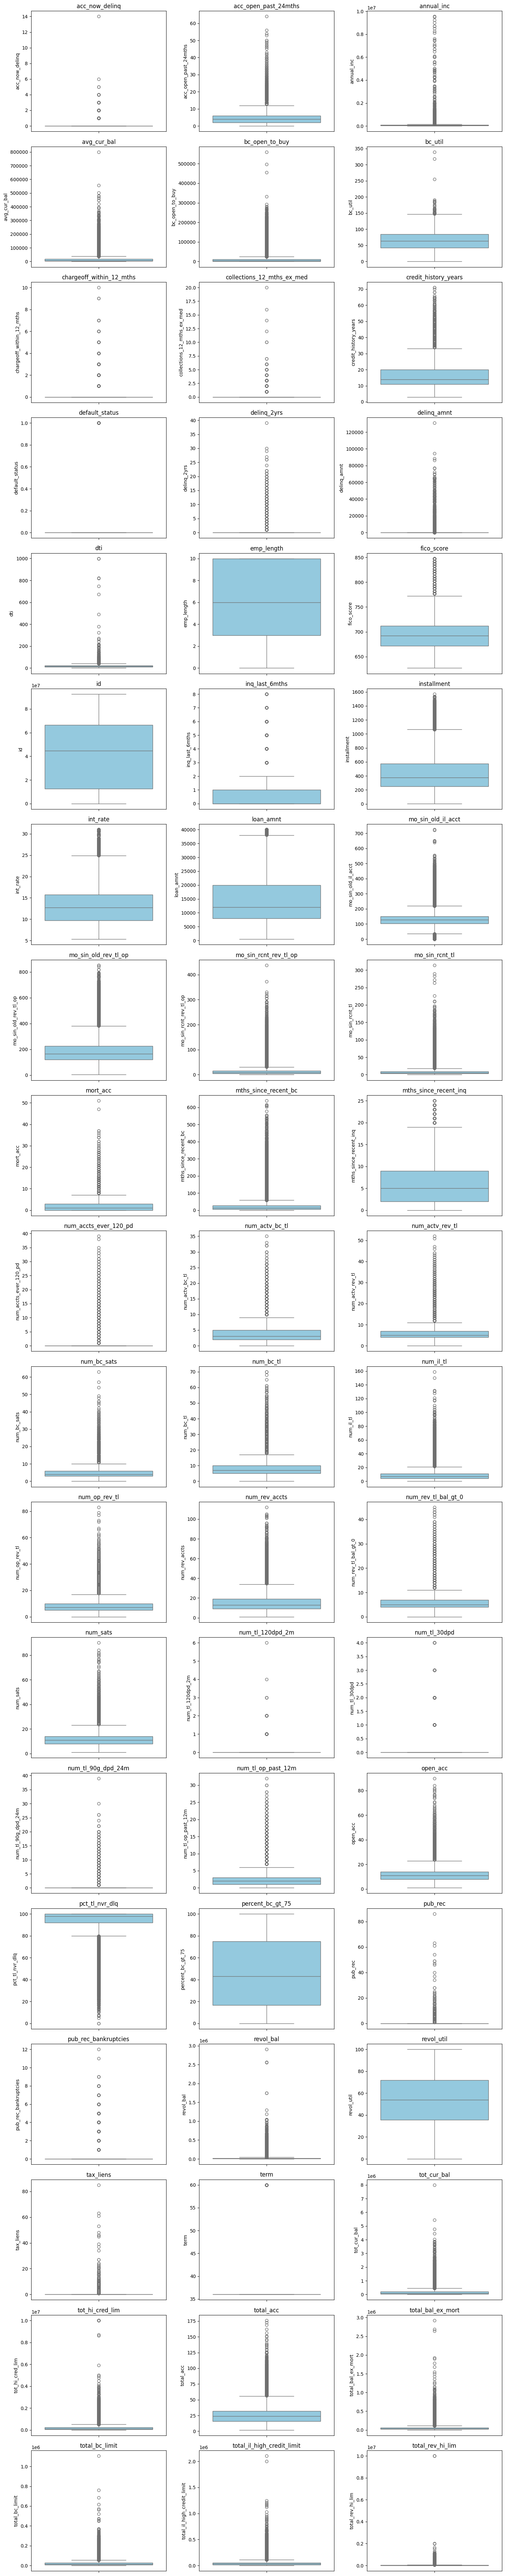

In [15]:
# -----------------------
# Inspect Distributions
# -----------------------
boxplots_numeric_columns(train_pdf_copy)

In [16]:
# ----------------------
# Check Outlier Values
# ----------------------
outlier_columns = sorted(list(train_pdf_copy.columns))
inspect_outliers_pd(df=train_pdf_copy, columns=outlier_columns, method="iqr")


📊 Inspecting Outliers for Column: `acc_now_delinq`
IQR Method | Q1=0.000, Q3=0.000, IQR=0.000
Lower Bound=0.000, Upper Bound=0.000
Outlier Count: 5340 (0.5% of valid 1071324)

🔼 Top Outliers (>0.000):
322047    14
882438     6
499775     5
813673     5
437706     4
Name: acc_now_delinq, dtype: int32

📊 Inspecting Outliers for Column: `acc_open_past_24mths`
IQR Method | Q1=2.000, Q3=6.000, IQR=4.000
Lower Bound=-4.000, Upper Bound=12.000
Outlier Count: 21365 (1.99% of valid 1071324)

🔼 Top Outliers (>12.000):
1281701    64.0
414405     56.0
451093     54.0
196641     53.0
185330     50.0
Name: acc_open_past_24mths, dtype: float64

📊 Inspecting Outliers for Column: `annual_inc`
IQR Method | Q1=45000.000, Q3=90000.000, IQR=45000.000
Lower Bound=-22500.000, Upper Bound=157500.000
Outlier Count: 49533 (4.62% of valid 1071324)

🔼 Top Outliers (>157500.000):
389576     9550000.0
971600     9500000.0
415325     9225000.0
1276411    9000000.0
278300     8706582.0
Name: annual_inc, dtype: float

Invalid Placeholders result in the lack of data integrity, and may cause our challenger model's performance to suffer. As such, let's create a `InvalidValueHandler` class to be included in our `sklearn` `Pipeline` object later on.


In [17]:
# ---------------------------------
# ⚠️ Detect & Remove Invalid Values
# ---------------------------------

from sklearn.base import BaseEstimator, TransformerMixin

# [Min Value , Max)
valid_values_mapping = {
    "dti": [0, 101],
    "fico_score": [300, 851],
    "tot_hi_cred_lim": [0, 9999999.0],
    "mo_sin_old_il_acct": [0, 999],
    "mo_sin_old_rev_tl_op": [0, 999],
    "total_rev_hi_lim": [0, 9_999_999],
}

print(f"Initial Row Count: {train_pdf_copy['id'].count()}")


# == Defining Classes to put in sklearn Pipeline Object ==
class InvalidValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, valid_values_dict):
        self.ref_dict = valid_values_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        valid_mask = pd.Series(True, index=X_transformed.index)  # Start with all True

        for key, value in self.ref_dict.items():
            min_val = value[0]
            max_val = value[1] - 1

            # == Keep updating boolean mask ==
            valid_mask &= valid_mask & (
                (X_transformed[key] >= min_val) & (X_transformed[key] <= max_val)
            )

        X_transformed = X_transformed.loc[valid_mask, :].copy()

        return X_transformed


invalid_values_handler = InvalidValueHandler(valid_values_mapping)
train_pdf_copy = invalid_values_handler.fit_transform(train_pdf_copy)
print(f"Final Row Count: {train_pdf_copy['id'].count()}")

Initial Row Count: 1071324
Final Row Count: 1071253


### 1.2 Remove Low Variance Features

Furthermore, it is useful to remove features of low variance, since 1 distinct value takes up majority of the data points. Though our XGBoost Decision Trees won't split on features with no variability, it is still good practice to drop these features, since they add no information.


In [18]:
def plot_low_variance_pies(df: pd.DataFrame, threshold: float = 0.95) -> list:
    """
    Find low-variance features and plot their value distribution as pie charts
    in a grid of subplots.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset.
    threshold : float, default=0.95
        Proportion cutoff for flagging low-variance features.

    Returns
    -------
    low_var_cols : list
        List of low-variance feature names.
    """
    # Find low variance columns
    low_var_cols = [
        col
        for col in df.columns
        if df[col].value_counts(dropna=False, normalize=True).iloc[0] >= threshold
    ]

    if not low_var_cols:
        print(f"No low-variance features found with threshold {threshold}.")
        return []

    # Setup subplot grid
    sns.set_theme(style="whitegrid")  # or another preferred style
    n = len(low_var_cols)
    ncols = 3  # adjust grid size if needed
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
    axes = axes.flatten()

    # Plot pies
    for i, col in enumerate(low_var_cols):
        # Custom autopct: only show percent if > 1%, else blank
        def autopct_fmt(pct):
            return f"{pct:.1f}%" if pct > 1 else ""

        df[col].value_counts(dropna=False).plot.pie(
            ax=axes[i],
            autopct=autopct_fmt,  # Key change: formatted autopct
            startangle=90,
            counterclock=False,
            labels=None,  # Key change: suppress slice labels
        )
        axes[i].set_title(f"{col} (low variance)")
        axes[i].set_ylabel("")

    # Hide unused subplots
    for j in range(len(low_var_cols), len(axes)):
        axes[j].axis("off")

    plt.title("Low Variance Features")
    plt.tight_layout()
    plt.show()

    return low_var_cols

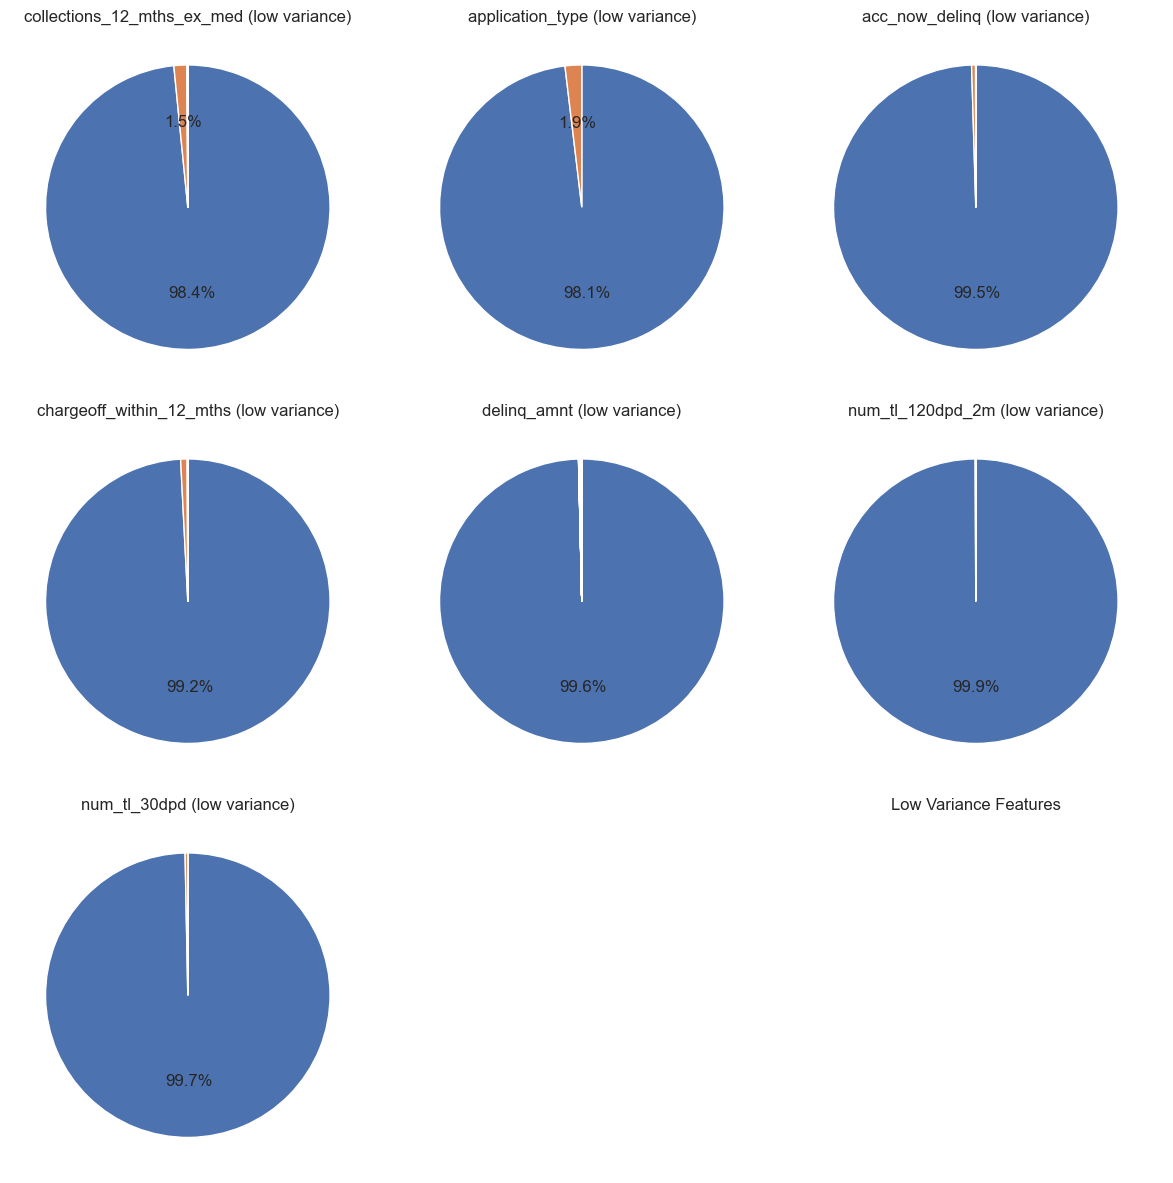

In [19]:
low_var_cols = plot_low_variance_pies(pdf, threshold=0.98)

In [20]:
# ----------------------------------------------
# Construct ZeroVarianceDropper: Remove Features
# ----------------------------------------------


class ZeroVarianceColumnDropper(BaseEstimator, TransformerMixin):
    """
    Drops specified columns from a pandas DataFrame.
    """

    def __init__(self, columns=None):
        self.columns = columns if columns is not None else []

    def fit(self, X, y=None):
        return self  # nothing to learn

    def transform(self, X):
        return X.drop(columns=self.columns, errors="ignore")


zero_var_columns = [
    "acc_now_deliinq",
    "chargeoff_within_12_mths",
    "delinq_amnt",
    "num_tl_120dpd_2m",
    "num_tl_30dpd",
]

print(f"Original Shape: {train_pdf_copy.shape}")
dropper = ZeroVarianceColumnDropper(columns=low_var_cols)
train_pdf_copy = dropper.fit_transform(train_pdf_copy)
print(f"Final Shape: {train_pdf_copy.shape}")

Original Shape: (1071253, 63)
Final Shape: (1071253, 56)


### 1.3 Skewness Transformation

Transformations of skewed features aren't typically needed for XGBoost, since XGBoost can handle skewed variables well (split on thresholds). However, we shall just inspect the skewness of our variables for formality. After running the cell below, it can be seen that many of our features are right skewed, just like many other financial datasets.


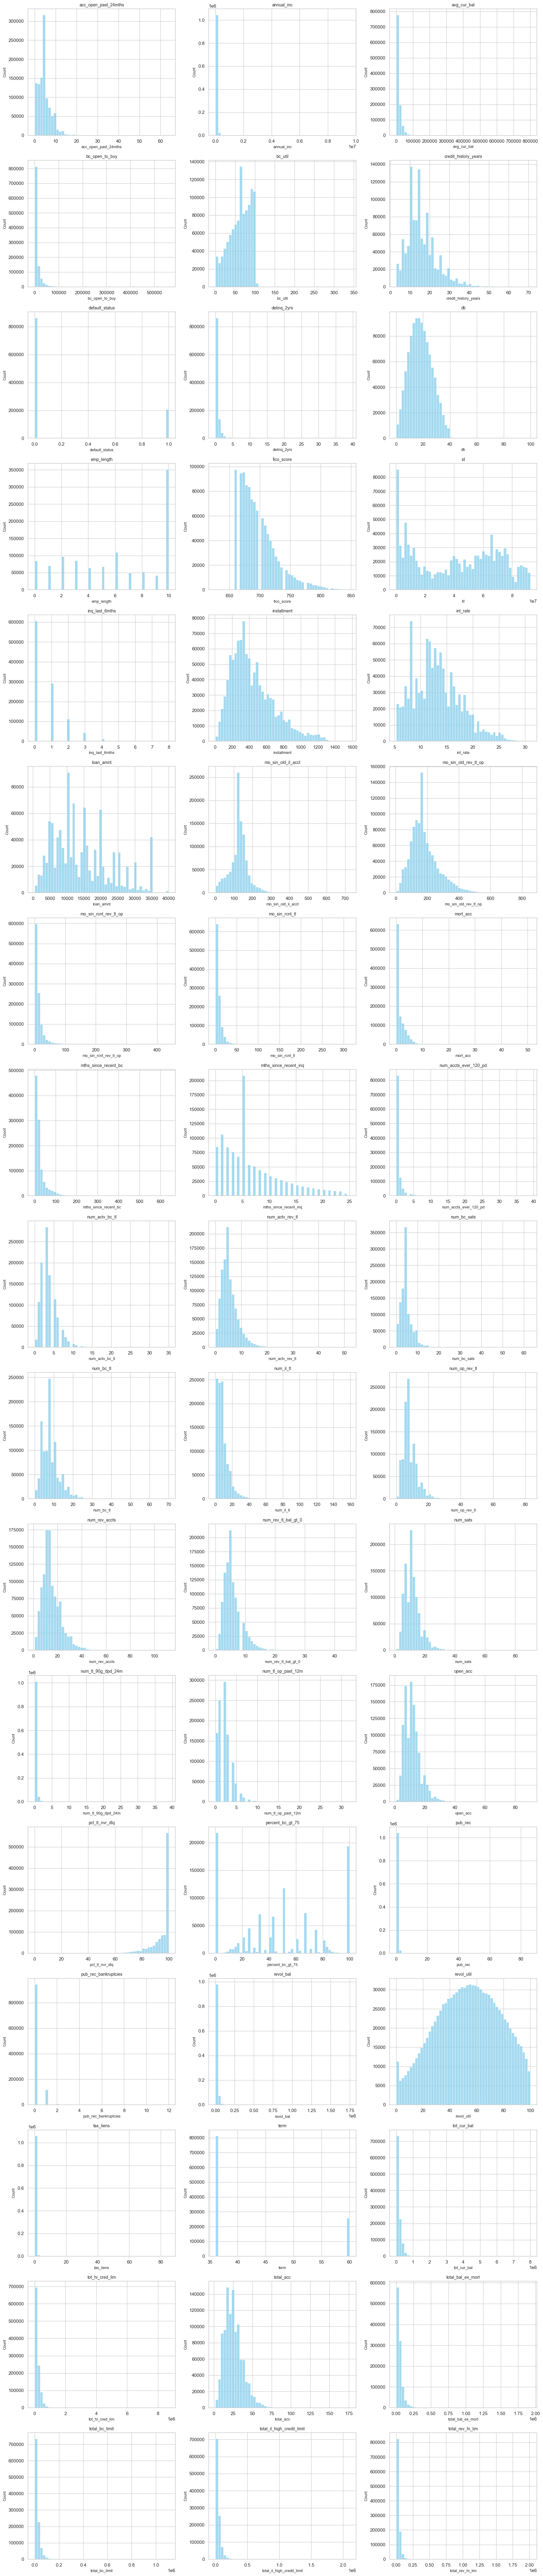

In [21]:
numeric_features = sorted(
    train_pdf_copy.select_dtypes(include="number").columns.tolist()
)
plot_kde_pdf(train_pdf_copy, numeric_features)

### 1.4 Categorical Encoding

In contrast to LightGBM (which shines when there are a lot of categorical features), it seems that our dataset has very few categorical features. Upon further inspection, it seems that although `term` & `emp_length` are `dtype=numeric`, `term` is a binary feature (36 vs 60), while `emp_length` has `10+`, which can mean a borrower is employed more than 10 years. Hence, they should be treated as categorical features instead. As such, we will be performing one-hot encoding / ordinal encoding for these features, since tree models have lesser multicollinearity concerns, like regression models.


In [22]:
# ----------------------------------------------
# Construct One Hot Encoder
# ----------------------------------------------


class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.columns_ = None  # will hold fitted dummy columns

    def fit(self, X, y=None):
        # Create dummies on fit to capture all dummy columns
        X_dummies = pd.get_dummies(X[self.columns], columns=self.columns, dtype="int")
        self.columns_ = X_dummies.columns
        return self

    def transform(self, X):
        # Create dummies on transform
        X_dummies = pd.get_dummies(X[self.columns], columns=self.columns)

        # Ensure all columns seen in fit are present, add missing with 0
        for col in self.columns_:
            if col not in X_dummies:
                X_dummies[col] = 0

        # Align columns order same as fit columns
        X_dummies = X_dummies[self.columns_]

        # Drop the original categorical columns from X and concatenate dummies
        X_remaining = X.drop(columns=self.columns)
        X_transformed = pd.concat(
            [X_remaining.reset_index(drop=True), X_dummies.reset_index(drop=True)],
            axis=1,
        )

        return X_transformed

In [23]:
category_columns = [
    "home_ownership",
    "verification_status",
    "initial_list_status",
    "term",
]

print(f"Original Shape: {train_pdf_copy.shape}")
one_hot_encoder = CustomOneHotEncoder(category_columns)
train_pdf_copy = one_hot_encoder.fit_transform(train_pdf_copy)
print(f"Final Shape: {train_pdf_copy.shape}")

Original Shape: (1071253, 56)
Final Shape: (1071253, 63)


In [24]:
# ----------------------------------------------
# Ordinal Encoding for `grade`& 'emp_length`
# ----------------------------------------------


class GradeEmpLengthEncoder(BaseEstimator, TransformerMixin):
    """
    Ordinal encoding for 'grade' and 'emp_length'.
      - grade: A..G -> 1..7
      - emp_length: already int (0..10) -> keep as is
    """

    def __init__(self, grade_col="grade", emp_col="emp_length"):
        self.grade_col = grade_col
        self.emp_col = emp_col
        self.grade_map = {g: i + 1 for i, g in enumerate(list("ABCDEFG"))}

    def fit(self, X, y=None):
        return self  # nothing to learn

    def transform(self, X):
        X = X.copy()
        # grade mapping
        if self.grade_col in X.columns:
            X[self.grade_col + "_ord"] = X[self.grade_col].map(self.grade_map)
        # emp_length already integer-coded
        if self.emp_col in X.columns:
            X[self.emp_col + "_ord"] = X[self.emp_col].astype(int)

        X = X.drop(columns=["grade", "emp_length"])
        return X


print(f"Original Shape: {train_pdf_copy.shape}")
grade_emp_length_encoder = GradeEmpLengthEncoder(
    grade_col="grade", emp_col="emp_length"
)
train_pdf_copy = grade_emp_length_encoder.fit_transform(train_pdf_copy)
print(f"Final Shape: {train_pdf_copy.shape}")

Original Shape: (1071253, 63)
Final Shape: (1071253, 63)


In [25]:
pd.set_option("display.max_columns", None)
train_pdf_copy.head()

,id,loan_amnt,int_rate,installment,annual_inc,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_f,initial_list_status_w,term_36,term_60,grade_ord,emp_length_ord
0,87023,7500.0,13.75,255.43,22000.0,2007-06-01,0,14.29,1,0,7,0,4175.0,51.5,8,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,662.0,False,False,True,False,True,False,False,True,False,True,False,5,0
1,106079,3500.0,9.96,112.87,13500.0,2007-07-01,0,16.44,0,1,10,0,2864.0,41.1,16,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,4,712.0,False,False,False,True,True,False,False,True,False,True,False,2,0
2,107136,12250.0,10.59,398.69,60000.0,2007-07-01,0,17.12,1,2,10,0,17214.0,8.1,24,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,38,747.0,False,False,False,True,True,False,False,True,False,True,False,3,3
3,92666,5000.0,9.33,159.77,180000.0,2007-07-01,0,11.93,0,1,16,0,60568.0,39.2,38,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,12,717.0,True,False,False,False,True,False,False,True,False,True,False,2,2
4,96844,5300.0,8.38,167.02,74000.0,2007-07-01,0,14.37,0,0,15,0,6844.0,14.4,29,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,15,797.0,True,False,False,False,True,False,False,True,False,True,False,1,7


# 2. Feature Engineering


In [26]:
train_pdf_copy_feat_en = train_pdf_copy.copy()

In [27]:
# -----------------------------
# Interaction Feature Functions
# -----------------------------
def plot_default_rate_bars(df, features, target="default_status", q=4, ncols=3):
    n = len(features)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
    axes = np.array(axes).reshape(-1)

    # Pre-binning all columns at once (batch processing)
    binned = {f: pd.qcut(df[f], q=q, duplicates="drop") for f in features}

    # Grouping is still per-feature but binning overhead is cut
    for i, f in enumerate(features):
        ax = axes[i]
        bins = binned[f]
        default_rate = df.groupby(bins, observed=True)[target].mean()
        default_rate.plot(kind="bar", ax=ax)
        ax.set_title(f"Default Rate by {f} (q={q})")
        ax.set_ylabel("Default Rate")
        ax.set_xlabel("")
        ax.tick_params(axis="x", rotation=45)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()


def plot_boxplots(df, features, target="default_status", cap_pct=0.99, ncols=3):
    n = len(features)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
    axes = np.array(axes).reshape(-1)

    # Process all capping in a single pass for feature columns
    capped_df = df.copy()
    for f in features:
        cap = capped_df[f].quantile(cap_pct)
        capped_df[f + "_cap"] = np.minimum(capped_df[f], cap)

    # Boxplot: now only plot with capped df
    for i, f in enumerate(features):
        ax = axes[i]
        sns.boxplot(
            x=target, y=f + "_cap", data=capped_df, ax=ax, hue=target, showfliers=False
        )
        ax.set_title(f"{f} (capped @{int(cap_pct*100)}th pct)")
        ax.set_xlabel(target)
        ax.set_ylabel(f)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()

In [28]:
sorted(train_pdf_copy_feat_en.columns)

['acc_open_past_24mths',
 'annual_inc',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'credit_history_years',
 'default_status',
 'delinq_2yrs',
 'dti',
 'emp_length_ord',
 'fico_score',
 'grade_ord',
 'home_ownership_MORTGAGE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'id',
 'initial_list_status_f',
 'initial_list_status_w',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'issue_d',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'open_acc',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'pub_rec',
 'pub_rec_bankruptcies',
 'revol_bal',
 'revol_util',
 'tax_liens',
 'term_36',
 'term_60',
 'tot_cur_bal',
 'tot_

In [29]:
# --------- tiny helper (vectorized, no Infs) ----------
def sdiv(num, den, eps=1e-6):
    num = pd.to_numeric(num, errors="coerce")
    den = pd.to_numeric(den, errors="coerce")
    n = num.to_numpy(dtype="float64")
    d = den.to_numpy(dtype="float64")
    out = np.full_like(d, np.nan, dtype="float64")
    np.divide(n, d, out=out, where=d > eps)  # only divide where safe
    return pd.Series(out, index=num.index)


# --------------------------------
# Creation of Interaction Features
# --------------------------------
train_pdf_copy_feat_en = train_pdf_copy_feat_en  # alias
eps = 1e-6

# precompute monthly income once
monthly_inc = train_pdf_copy_feat_en["annual_inc"] / 12

# Products

# == DTI ==
train_pdf_copy_feat_en["dti_emp_inter&"] = train_pdf_copy_feat_en[
    "dti"
] * train_pdf_copy_feat_en["emp_length_ord"].fillna(0)

train_pdf_copy_feat_en["grade_dti&"] = (
    train_pdf_copy_feat_en["grade_ord"] * train_pdf_copy_feat_en["dti"]
)
train_pdf_copy_feat_en["loan_int_product&"] = (
    train_pdf_copy_feat_en["loan_amnt"] * train_pdf_copy_feat_en["int_rate"]
)
train_pdf_copy_feat_en["util_grade&"] = (
    train_pdf_copy_feat_en["revol_util"].fillna(0) * train_pdf_copy_feat_en["grade_ord"]
)
train_pdf_copy_feat_en["income_stability&"] = (
    train_pdf_copy_feat_en["emp_length_ord"].fillna(0)
    * train_pdf_copy_feat_en["annual_inc"]
)


ratio_specs = {
    # == Liabilities ==
    "monthly_liabilities&": (
        train_pdf_copy_feat_en["dti"] * monthly_inc
        + train_pdf_copy_feat_en["installment"],
        monthly_inc,
    ),
    "income_to_payment&": (monthly_inc, train_pdf_copy_feat_en["installment"]),
    "installment_ratio&": (
        train_pdf_copy_feat_en["installment"],
        train_pdf_copy_feat_en["loan_amnt"],
    ),
    "payment_inc_ratio&": (
        train_pdf_copy_feat_en["installment"],
        train_pdf_copy_feat_en["annual_inc"],
    ),
    # == Credit Utilization Interactions ==
    "mthly_revolving_util&": (
        train_pdf_copy_feat_en["revol_bal"],
        train_pdf_copy_feat_en["annual_inc"],
    ),
    "revolving_to_installment&": (
        train_pdf_copy_feat_en["revol_bal"],
        train_pdf_copy_feat_en["installment"],
    ),
}

for name, (num, den) in ratio_specs.items():
    train_pdf_copy_feat_en[name] = sdiv(num, den, eps=eps)

# your shortlist (unchanged)
new_feats = [feature for feature in train_pdf_copy_feat_en.columns if "&" in feature]

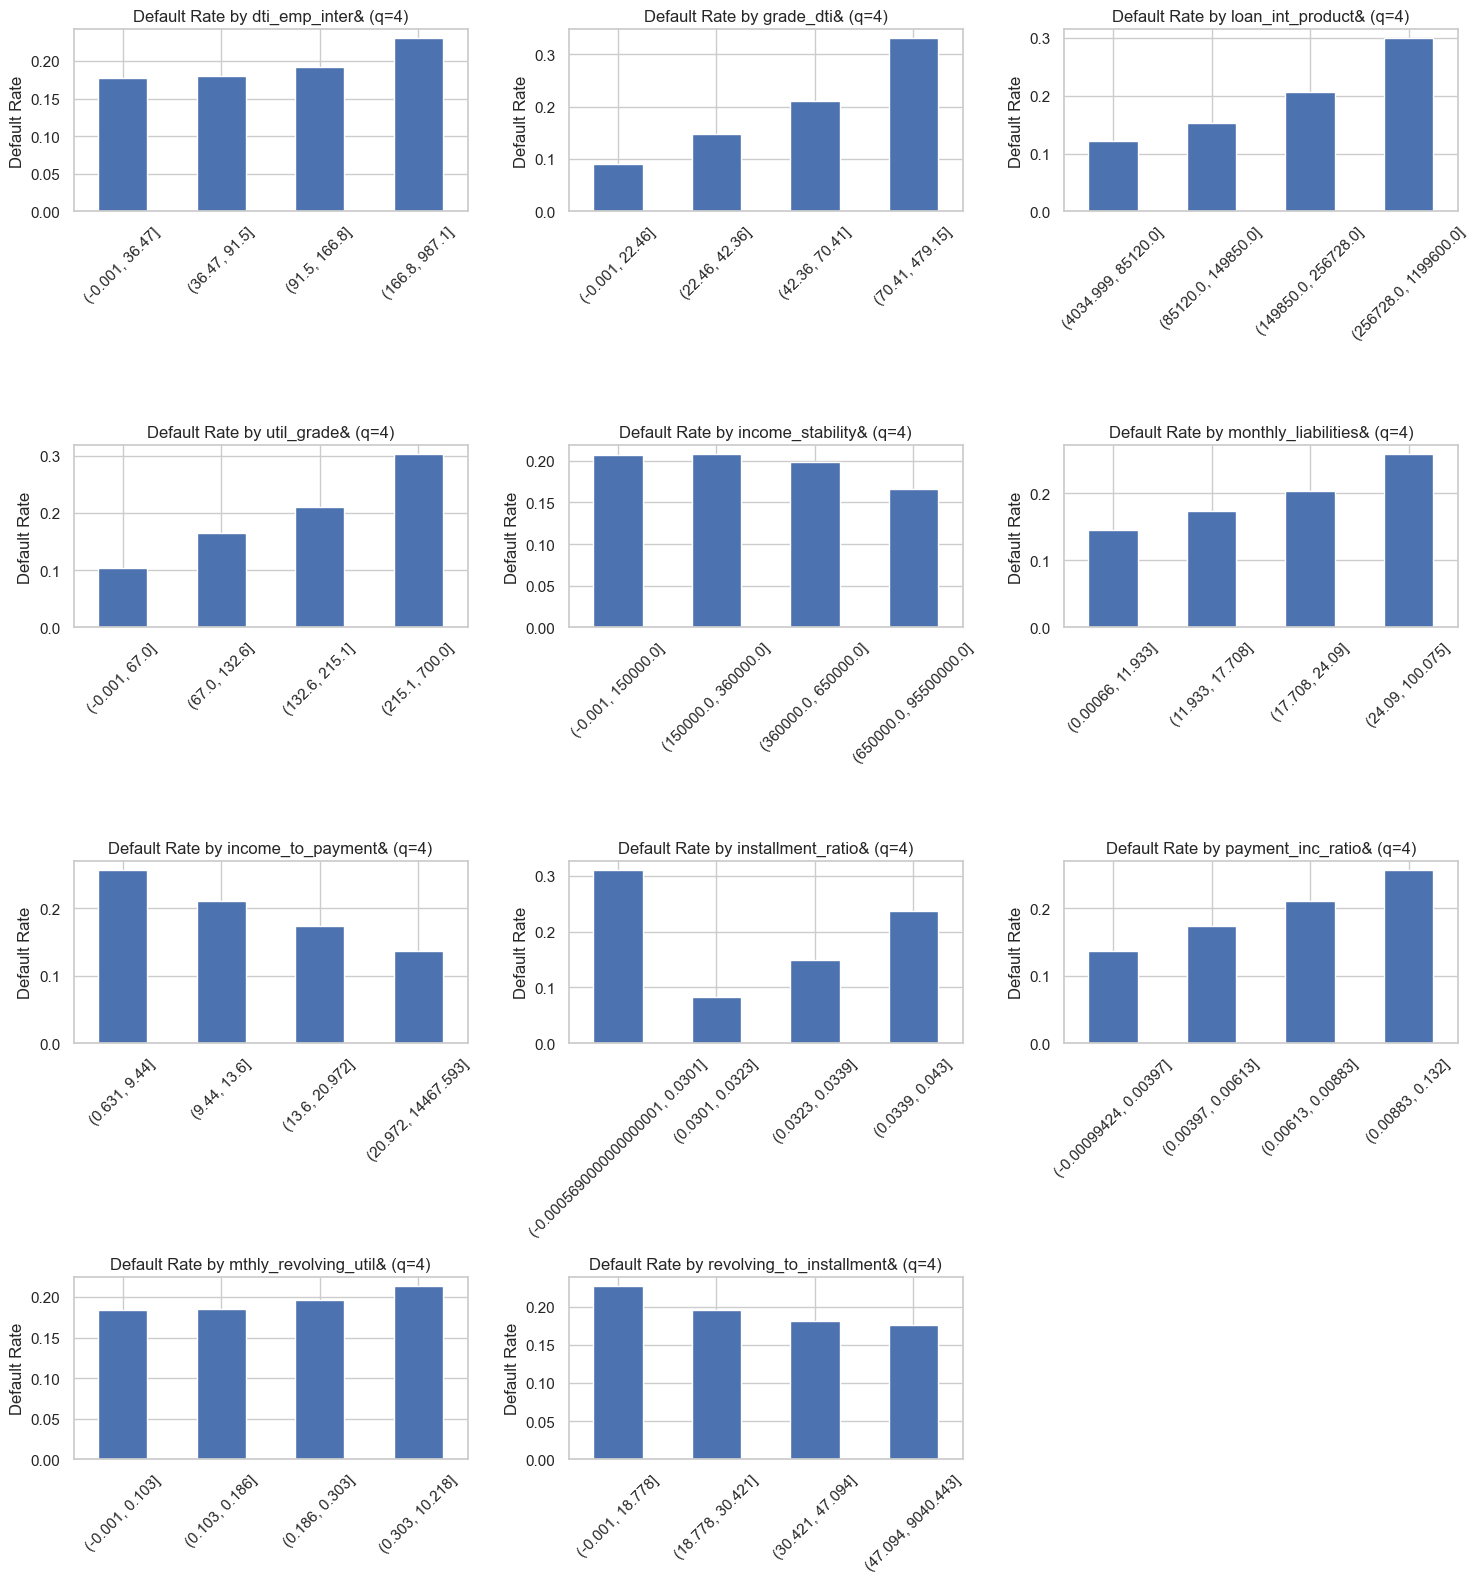

In [30]:
# -------------------------------------------------
# Check Interaction Feature (Trend Checking)
# -------------------------------------------------
plot_default_rate_bars(
    train_pdf_copy_feat_en, new_feats, target="default_status", q=4, ncols=3
)

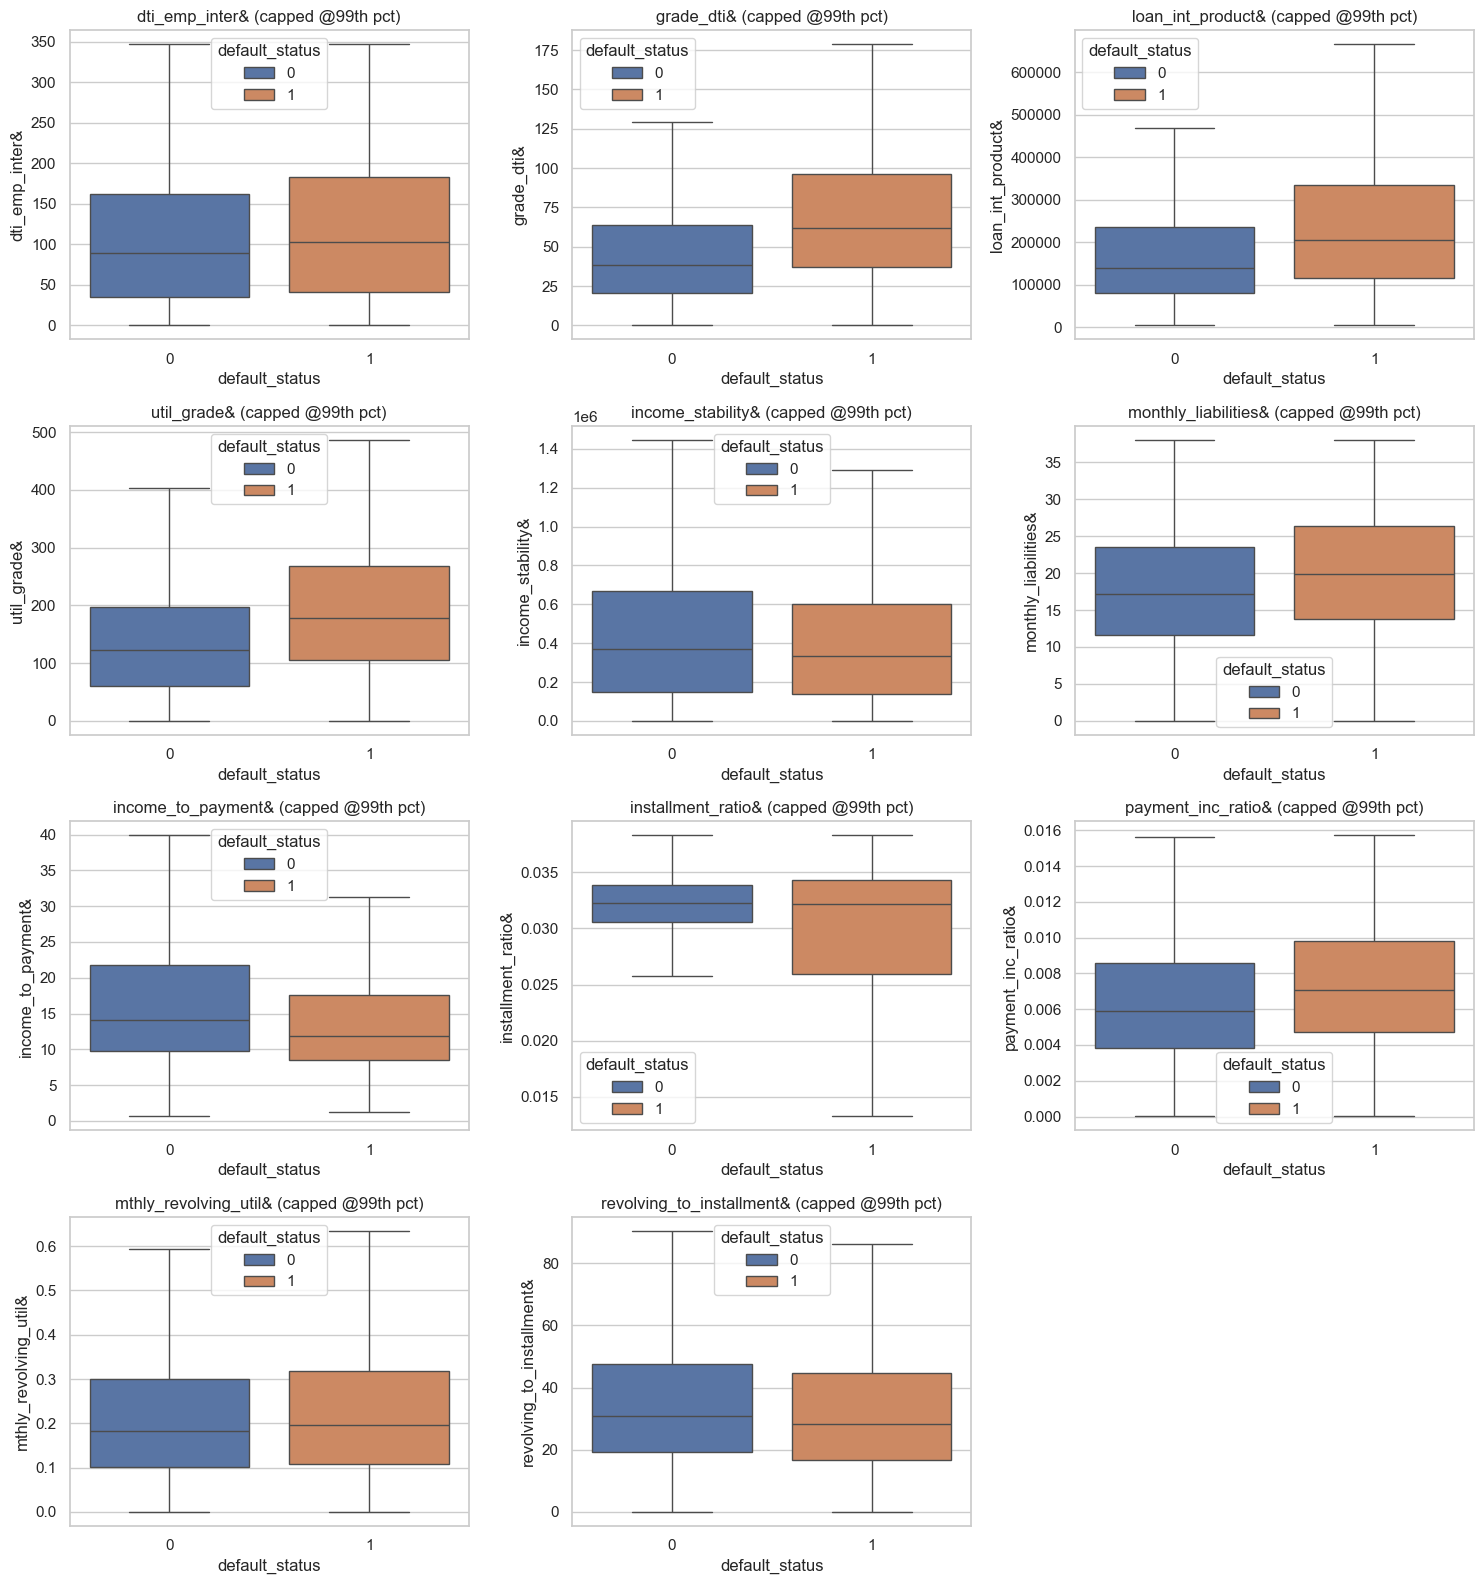

In [31]:
# -------------------------------------------------
# Check Interaction Feature Seperability of Classes
# -------------------------------------------------

plot_boxplots(
    train_pdf_copy_feat_en, new_feats, target="default_status", cap_pct=0.99, ncols=3
)

We can observe the newly created interaction features trend with the mean default rate (whether it is non-monotonic / monotonic). Either way, XGBoost captures them well. However, the boxplots are important, they portray the separaibility of classes by each interaction feature. We want interaction features that have high separability between defaulted / non-defaulted loans. We shall filter final useful interaction features in the list below.


In [32]:
final_interaction_features = [
    "grade_dti&",
    "loan_int_product&",
    "util_grade&",
    "monthly_liabilities&",
    "income_to_payment&",
    "installment_inc_ratio&",
]

In [33]:
class InteractionFeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # simple products (no division)
        X["grade_x_dti"] = X["grade_ord"] * X["dti"]
        X["loan_x_int"] = X["loan_amnt"] * X["int_rate"]
        X["util_x_grade"] = X["revol_util"].fillna(0) * X["grade_ord"]

        # ratios with safe division
        monthly_inc = X["annual_inc"] / 12.0

        X["monthly_liabilities&"] = sdiv(
            X["dti"] * monthly_inc + X["installment"], monthly_inc
        )
        X["income_to_payment"] = sdiv(monthly_inc, X["installment"])
        X["installment_inc_ratio"] = sdiv(X["installment"], X["annual_inc"])

        return X


print(f"Original Shape: {train_pdf_copy.shape}")
interaction_feat_creator = InteractionFeatureCreator()
train_pdf_copy_feat_en = interaction_feat_creator.fit_transform(train_pdf_copy_feat_en)
print(f"Final Shape: {train_pdf_copy.shape}")


train_pdf_copy_feat_en.head()

Original Shape: (1071253, 63)
Final Shape: (1071253, 63)


,id,loan_amnt,int_rate,installment,annual_inc,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_f,initial_list_status_w,term_36,term_60,grade_ord,emp_length_ord,dti_emp_inter&,grade_dti&,loan_int_product&,util_grade&,income_stability&,monthly_liabilities&,income_to_payment&,installment_ratio&,payment_inc_ratio&,mthly_revolving_util&,revolving_to_installment&,grade_x_dti,loan_x_int,util_x_grade,income_to_payment,installment_inc_ratio
0,87023,7500.0,13.75,255.43,22000.0,2007-06-01,0,14.29,1,0,7,0,4175.0,51.5,8,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,662.0,False,False,True,False,True,False,False,True,False,True,False,5,0,0.00,71.45,103125.0,257.5,0.0,14.429325,7.177439,0.034057,0.011610,0.189773,16.344987,71.45,103125.0,257.5,7.177439,0.011610
1,106079,3500.0,9.96,112.87,13500.0,2007-07-01,0,16.44,0,1,10,0,2864.0,41.1,16,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,4,712.0,False,False,False,True,True,False,False,True,False,True,False,2,0,0.00,32.88,34860.0,82.2,0.0,16.540329,9.967219,0.032249,0.008361,0.212148,25.374324,32.88,34860.0,82.2,9.967219,0.008361
2,107136,12250.0,10.59,398.69,60000.0,2007-07-01,0,17.12,1,2,10,0,17214.0,8.1,24,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,38,747.0,False,False,False,True,True,False,False,True,False,True,False,3,3,51.36,51.36,129727.5,24.3,180000.0,17.199738,12.541072,0.032546,0.006645,0.286900,43.176403,51.36,129727.5,24.3,12.541072,0.006645
3,92666,5000.0,9.33,159.77,180000.0,2007-07-01,0,11.93,0,1,16,0,60568.0,39.2,38,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,12,717.0,True,False,False,False,True,False,False,True,False,True,False,2,2,23.86,23.86,46650.0,78.4,360000.0,11.940651,93.884960,0.031954,0.000888,0.336489,379.094949,23.86,46650.0,78.4,93.884960,0.000888
4,96844,5300.0,8.38,167.02,74000.0,2007-07-01,0,14.37,0,0,15,0,6844.0,14.4,29,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,15,797.0,True,False,False,False,True,False,False,True,False,True,False,1,7,100.59,14.37,44414.0,14.4,518000.0,14.397084,36.921726,0.031513,0.002257,0.092486,40.977128,14.37,44414.0,14.4,36.921726,0.002257


# 3. XGBoost Model Training

deal with class imbalance with xgboost parameter , pipeline object


In [34]:
# -----------------------------------------------
# Define Pipeline to Transform Train & Test Data
# -----------------------------------------------
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline(
    steps=[
        ("invalid_values_rm", invalid_values_handler),
        ("zero_var_rm", dropper),
        ("one_hot", one_hot_encoder),
        ("ordinal_encoder", grade_emp_length_encoder),
        ("interaction_features_creator", interaction_feat_creator),
    ]
)

In [35]:
# -----------------------------------------------
# Transform Train & Test Data, using Pipeline
# -----------------------------------------------

# == Train-Test Split (in case) ==
train_pdf, test_pdf = train_test_split_oot(pdf)

# == Train Data should learn from Pipeline Object ==
full_pipeline.fit(train_pdf)
train_pdf_final = full_pipeline.transform(train_pdf)
test_pdf_final = full_pipeline.transform(test_pdf)

,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
665474,87023,7500.0,36,13.75,255.43,E,0,OWN,22000.0,Not Verified,2007-06-01,0,14.29,1,0,7,0,4175.0,51.5,8,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,662.0
665495,106079,3500.0,36,9.96,112.87,B,0,RENT,13500.0,Not Verified,2007-07-01,0,16.44,0,1,10,0,2864.0,41.1,16,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,4,712.0
665504,107136,12250.0,36,10.59,398.69,C,3,RENT,60000.0,Not Verified,2007-07-01,0,17.12,1,2,10,0,17214.0,8.1,24,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,38,747.0
665503,92666,5000.0,36,9.33,159.77,B,2,MORTGAGE,180000.0,Not Verified,2007-07-01,0,11.93,0,1,16,0,60568.0,39.2,38,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,12,717.0
665502,96844,5300.0,36,8.38,167.02,A,7,MORTGAGE,74000.0,Not Verified,2007-07-01,0,14.37,0,0,15,0,6844.0,14.4,29,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,15,797.0


,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
53967,90697427,19000.0,36,10.49,617.46,B,6,RENT,70000.00,Source Verified,2016-10-01,0,16.94,0,0,8,2,3456.0,39.3,20,w,0,Individual,0,20086.0,8800.0,6.0,3348.0,2939.0,51.0,0.0,0.0,133.0,252.0,10.0,10.0,0.0,23.0,2.0,0.0,1.0,2.0,1.0,1.0,10.0,5.0,8.0,2.0,8.0,0.0,0.0,0.0,2.0,100.0,0.0,2.0,0.0,35512.0,20086.0,6000.0,26712.0,21,667.0
53968,91453246,12000.0,36,11.49,395.66,B,8,MORTGAGE,60000.00,Source Verified,2016-10-01,0,2.22,0,0,4,1,849.0,42.5,11,w,0,Individual,0,6214.0,2000.0,1.0,2071.0,1151.0,42.5,0.0,0.0,150.0,305.0,23.0,23.0,1.0,23.0,12.0,0.0,2.0,2.0,2.0,4.0,5.0,3.0,5.0,2.0,4.0,0.0,0.0,0.0,0.0,90.9,0.0,1.0,0.0,10877.0,6214.0,2000.0,8877.0,25,692.0
53969,91143299,7000.0,36,6.99,216.11,A,6,OWN,36120.72,Not Verified,2016-10-01,0,13.94,0,0,4,0,2175.0,10.0,13,w,0,Individual,0,4288.0,21800.0,2.0,1072.0,16625.0,11.6,0.0,0.0,140.0,132.0,24.0,20.0,0.0,24.0,12.0,0.0,2.0,2.0,2.0,5.0,4.0,3.0,9.0,2.0,4.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,29800.0,4288.0,18800.0,8000.0,11,777.0
53970,91341420,4950.0,36,12.79,166.29,C,6,RENT,13800.00,Verified,2016-10-01,0,10.52,0,1,2,0,7254.0,42.7,12,w,0,Individual,0,7254.0,17000.0,1.0,3627.0,9746.0,42.7,0.0,0.0,144.0,185.0,10.0,10.0,0.0,10.0,2.0,0.0,2.0,2.0,2.0,9.0,2.0,2.0,10.0,2.0,2.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,17000.0,7254.0,17000.0,0.0,15,737.0
53971,91527133,25900.0,36,13.49,878.80,C,6,MORTGAGE,54000.00,Verified,2016-10-01,1,4.42,0,1,8,0,8394.0,14.4,20,w,0,Individual,0,209058.0,58300.0,3.0,29865.0,29606.0,22.1,0.0,0.0,146.0,209.0,27.0,6.0,4.0,41.0,1.0,0.0,2.0,2.0,3.0,7.0,2.0,6.0,13.0,2.0,8.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,262400.0,8394.0,38000.0,0.0,17,802.0


In [36]:
from IPython.display import display

display(train_pdf_final.head())
display(test_pdf_final.head())

,id,loan_amnt,int_rate,installment,annual_inc,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_f,initial_list_status_w,term_36,term_60,grade_ord,emp_length_ord,grade_x_dti,loan_x_int,util_x_grade,monthly_liabilities&,income_to_payment,installment_inc_ratio
0,87023,7500.0,13.75,255.43,22000.0,2007-06-01,0,14.29,1,0,7,0,4175.0,51.5,8,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,662.0,False,False,True,False,True,False,False,True,False,True,False,5,0,71.45,103125.0,257.5,14.429325,7.177439,0.011610
1,106079,3500.0,9.96,112.87,13500.0,2007-07-01,0,16.44,0,1,10,0,2864.0,41.1,16,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,4,712.0,False,False,False,True,True,False,False,True,False,True,False,2,0,32.88,34860.0,82.2,16.540329,9.967219,0.008361
2,107136,12250.0,10.59,398.69,60000.0,2007-07-01,0,17.12,1,2,10,0,17214.0,8.1,24,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,38,747.0,False,False,False,True,True,False,False,True,False,True,False,3,3,51.36,129727.5,24.3,17.199738,12.541072,0.006645
3,92666,5000.0,9.33,159.77,180000.0,2007-07-01,0,11.93,0,1,16,0,60568.0,39.2,38,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,12,717.0,True,False,False,False,True,False,False,True,False,True,False,2,2,23.86,46650.0,78.4,11.940651,93.884960,0.000888
4,96844,5300.0,8.38,167.02,74000.0,2007-07-01,0,14.37,0,0,15,0,6844.0,14.4,29,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,15,797.0,True,False,False,False,True,False,False,True,False,True,False,1,7,14.37,44414.0,14.4,14.397084,36.921726,0.002257


,id,loan_amnt,int_rate,installment,annual_inc,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_f,initial_list_status_w,term_36,term_60,grade_ord,emp_length_ord,grade_x_dti,loan_x_int,util_x_grade,monthly_liabilities&,income_to_payment,installment_inc_ratio
0,90697427,19000.0,10.49,617.46,70000.00,2016-10-01,0,16.94,0,0,8,2,3456.0,39.3,20,20086.0,8800.0,6.0,3348.0,2939.0,51.0,133.0,252.0,10.0,10.0,0.0,23.0,2.0,0.0,1.0,2.0,1.0,1.0,10.0,5.0,8.0,2.0,8.0,0.0,2.0,100.0,0.0,2.0,0.0,35512.0,20086.0,6000.0,26712.0,21,667.0,False,False,False,True,False,True,False,False,True,True,False,2,6,33.88,199310.0,78.6,17.045850,9.447306,0.008821
1,91453246,12000.0,11.49,395.66,60000.00,2016-10-01,0,2.22,0,0,4,1,849.0,42.5,11,6214.0,2000.0,1.0,2071.0,1151.0,42.5,150.0,305.0,23.0,23.0,1.0,23.0,12.0,0.0,2.0,2.0,2.0,4.0,5.0,3.0,5.0,2.0,4.0,0.0,0.0,90.9,0.0,1.0,0.0,10877.0,6214.0,2000.0,8877.0,25,692.0,True,False,False,False,False,True,False,False,True,True,False,2,8,4.44,137880.0,85.0,2.299132,12.637113,0.006594
2,91143299,7000.0,6.99,216.11,36120.72,2016-10-01,0,13.94,0,0,4,0,2175.0,10.0,13,4288.0,21800.0,2.0,1072.0,16625.0,11.6,140.0,132.0,24.0,20.0,0.0,24.0,12.0,0.0,2.0,2.0,2.0,5.0,4.0,3.0,9.0,2.0,4.0,0.0,0.0,100.0,0.0,0.0,0.0,29800.0,4288.0,18800.0,8000.0,11,777.0,False,False,True,False,True,False,False,False,True,True,False,1,6,13.94,48930.0,10.0,14.011796,13.928370,0.005983
3,91341420,4950.0,12.79,166.29,13800.00,2016-10-01,0,10.52,0,1,2,0,7254.0,42.7,12,7254.0,17000.0,1.0,3627.0,9746.0,42.7,144.0,185.0,10.0,10.0,0.0,10.0,2.0,0.0,2.0,2.0,2.0,9.0,2.0,2.0,10.0,2.0,2.0,0.0,1.0,100.0,0.0,0.0,0.0,17000.0,7254.0,17000.0,0.0,15,737.0,False,False,False,True,False,False,True,False,True,True,False,3,6,31.56,63310.5,128.1,10.664600,6.915629,0.012050
4,91527133,25900.0,13.49,878.80,54000.00,2016-10-01,1,4.42,0,1,8,0,8394.0,14.4,20,209058.0,58300.0,3.0,29865.0,29606.0,22.1,146.0,209.0,27.0,6.0,4.0,41.0,1.0,0.0,2.0,2.0,3.0,7.0,2.0,6.0,13.0,2.0,8.0,0.0,2.0,100.0,0.0,0.0,0.0,262400.0,8394.0,38000.0,0.0,17,802.0,True,False,False,False,False,False,True,False,True,True,False,3,6,13.26,349391.0,43.2,4.615289,5.120619,0.016274


In [ ]:
X_train_pdf_final = train_pdf_final.drop(columns["issue_d", "default_status"])
y_train_final = train_pdf_final["default_status"]

X_test_final = test_pdf_final.drop(columns["issue_d", "default_status"])
y_test_final = test_pdf_final["default_status"]

In [ ]:
import xgboost as xgb

scale_pos_weight_val = sum(
    X_train_pdf_final[X_train_pdf_final["default_status"] == 0]
) / sum(X_train_pdf_final[X_train_pdf_final["default_status"] == 1])


xgb_1st = xgb.XGBClassifier(
    objective="binary:logistic",  # binary classification problem
    random_state=42,
    scale_pos_weight=scale_pos_weight_val,  # for class imbalance
)

# 4. Hyperparameter Tuning


# 5. SHAP Explanability
